In [1]:
import pandas as pd
import os
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_style('whitegrid')               # affects the visual properties of plots
import warnings                         # to avoid warings
warnings.filterwarnings("ignore")
# Downloading punkt and wordnet from NLTK
nltk.download('punkt')
nltk.download('wordnet')
# Downloading the stop words list
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kyasa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kyasa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kyasa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df = pd.read_csv('data/News_dataset.csv', sep =';')
df.head()

,File_Name,Content,Category,Complete_Filename
0,001.txt,Ad sales boost Time Warner profit\r\n\r\nQuart...,business,001.txt-business
1,002.txt,Dollar gains on Greenspan speech\r\n\r\nThe do...,business,002.txt-business
2,003.txt,Yukos unit buyer faces loan claim\r\n\r\nThe o...,business,003.txt-business
3,004.txt,High fuel prices hit BA's profits\r\n\r\nBriti...,business,004.txt-business
4,005.txt,Pernod takeover talk lifts Domecq\r\n\r\nShare...,business,005.txt-business


In [3]:
df['News_length'] = df['Content'].str.len()
df['News_length'].describe()

count     2225.000000
mean      2274.363596
std       1370.782663
min        506.000000
25%       1454.000000
50%       1978.000000
75%       2814.000000
max      25596.000000
Name: News_length, dtype: float64

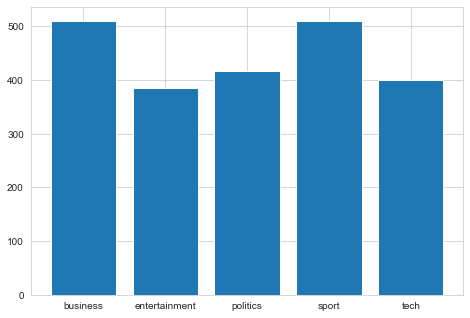

In [4]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
categories = os.listdir(path='data/bbc')
n_files = []
for i in categories:
    n = len(os.listdir(path = 'data/bbc/'+i))
    n_files.append(int(n))

ax.bar(categories, n_files)
plt.show()

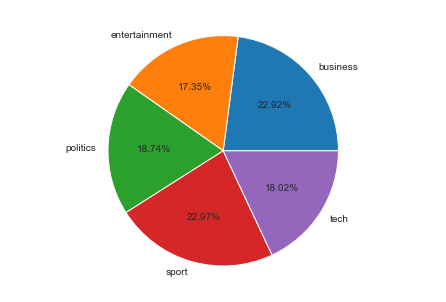

In [5]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('equal')
ax.pie(n_files, labels=categories , autopct='%1.2f%%')
plt.show()

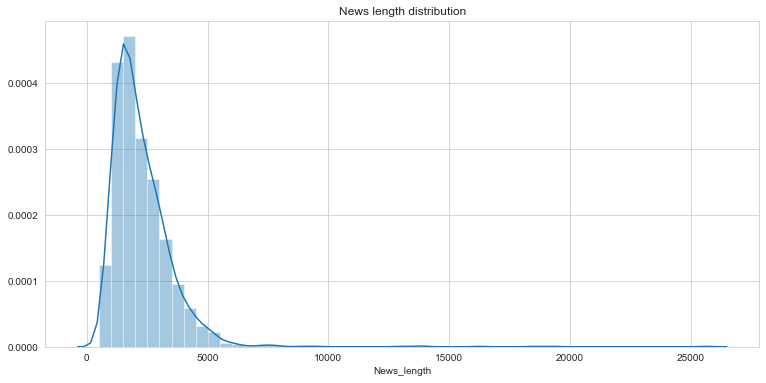

In [6]:
plt.figure(figsize=(12.8,6))
sb.distplot(df['News_length']).set_title('News length distribution');

Text(0.5, 1.0, 'News lehgth distriution')

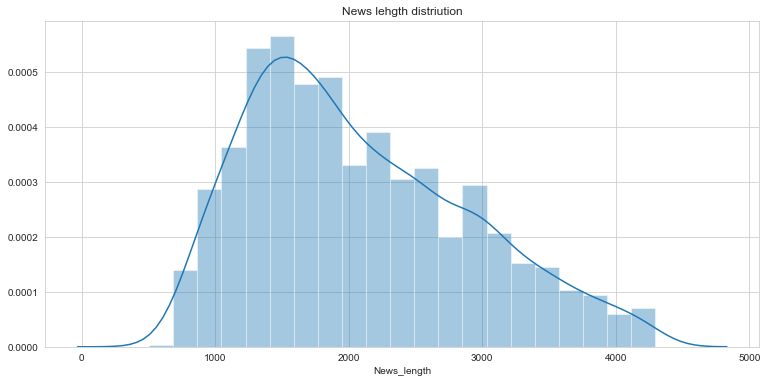

In [7]:
threshold = df['News_length'].quantile(0.95)
data95 = df[df['News_length'] < threshold]
plt.figure(figsize=(12.8,6))
sb.distplot(data95['News_length']).set_title('News lehgth distriution')

In [8]:
datamore10k = df[df['News_length'] > 10000]
print("Number of article with words more than 10k:",len(datamore10k))


Number of article with words more than 10k: 7


In [9]:
with open('Pickles/News_dataset.pickle', 'wb') as output:
    pickle.dump(df, output)

In [10]:
df.head()

,File_Name,Content,Category,Complete_Filename,News_length
0,001.txt,Ad sales boost Time Warner profit\r\n\r\nQuart...,business,001.txt-business,2569
1,002.txt,Dollar gains on Greenspan speech\r\n\r\nThe do...,business,002.txt-business,2257
2,003.txt,Yukos unit buyer faces loan claim\r\n\r\nThe o...,business,003.txt-business,1557
3,004.txt,High fuel prices hit BA's profits\r\n\r\nBriti...,business,004.txt-business,2421
4,005.txt,Pernod takeover talk lifts Domecq\r\n\r\nShare...,business,005.txt-business,1575


In [11]:
df.loc[1]['Content']

'Dollar gains on Greenspan speech\r\n\r\nThe dollar has hit its highest level against the euro in almost three months after the Federal Reserve head said the US trade deficit is set to stabilise.\r\n\r\nAnd Alan Greenspan highlighted the US government\'s willingness to curb spending and rising household savings as factors which may help to reduce it. In late trading in New York, the dollar reached $1.2871 against the euro, from $1.2974 on Thursday. Market concerns about the deficit has hit the greenback in recent months. On Friday, Federal Reserve chairman Mr Greenspan\'s speech in London ahead of the meeting of G7 finance ministers sent the dollar higher after it had earlier tumbled on the back of worse-than-expected US jobs data. "I think the chairman\'s taking a much more sanguine view on the current account deficit than he\'s taken for some time," said Robert Sinche, head of currency strategy at Bank of America in New York. "He\'s taking a longer-term view, laying out a set of cond

In [12]:
# \r and \n
df['Content_Parsed_1'] = df['Content'].str.replace("\r", " ")
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace("\n", " ")
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace("    ", " ")
# " when quoting text
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace('"', '')
# Lowercasing the text
df['Content_Parsed_2'] = df['Content_Parsed_1'].str.lower()
punctuation_signs = list("?:!.,;")
df['Content_Parsed_3'] = df['Content_Parsed_2']

for punct_sign in punctuation_signs:
    df['Content_Parsed_3'] = df['Content_Parsed_3'].str.replace(punct_sign, '')
    df['Content_Parsed_4'] = df['Content_Parsed_3'].str.replace("'s", "")
    

In [13]:

# Saving the lemmatizer into an object
wordnet_lemmatizer = WordNetLemmatizer()

In [14]:
nrows = len(df)
lemmatized_text_list = []

for row in range(0, nrows):
    
    # Create an empty list containing lemmatized words
    lemmatized_list = []
    
    # Save the text and its words into an object
    text = df.loc[row]['Content_Parsed_4']
    text_words = text.split(" ")

    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        
    # Join the list
    lemmatized_text = " ".join(lemmatized_list)
    
    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)

In [15]:
df['Content_Parsed_5'] = lemmatized_text_list

In [16]:
# Downloading the stop words list
nltk.download('stopwords')
# Loading the stop words in english
stop_words = list(stopwords.words('english'))
df['Content_Parsed_6'] = df['Content_Parsed_5']

for stop_word in stop_words:

    regex_stopword = r"\b" + stop_word + r"\b"
    df['Content_Parsed_6'] = df['Content_Parsed_6'].str.replace(regex_stopword, '')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kyasa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
df.loc[5]['Content']

'Japan narrowly escapes recession\r\n\r\nJapan\'s economy teetered on the brink of a technical recession in the three months to September, figures show.\r\n\r\nRevised figures indicated growth of just 0.1% - and a similar-sized contraction in the previous quarter. On an annual basis, the data suggests annual growth of just 0.2%, suggesting a much more hesitant recovery than had previously been thought. A common technical definition of a recession is two successive quarters of negative growth.\r\n\r\nThe government was keen to play down the worrying implications of the data. "I maintain the view that Japan\'s economy remains in a minor adjustment phase in an upward climb, and we will monitor developments carefully," said economy minister Heizo Takenaka. But in the face of the strengthening yen making exports less competitive and indications of weakening economic conditions ahead, observers were less sanguine. "It\'s painting a picture of a recovery... much patchier than previously thoug

In [18]:
df.loc[5]['Content_Parsed_6']

'japan narrowly escape recession japan economy teeter   brink   technical recession   three months  september figure show revise figure indicate growth   01% -   similar-sized contraction   previous quarter   annual basis  data suggest annual growth   02% suggest  much  hesitant recovery   previously  think  common technical definition   recession  two successive quarter  negative growth  government  keen  play   worry implications   data  maintain  view  japan economy remain   minor adjustment phase   upward climb    monitor developments carefully say economy minister heizo takenaka    face   strengthen yen make export less competitive  indications  weaken economic condition ahead observers  less sanguine  paint  picture   recovery much patchier  previously think say paul sheard economist  lehman brothers  tokyo improvements   job market apparently  yet  fee   domestic demand  private consumption   02%   third quarter'

In [19]:
df.head(1)


,File_Name,Content,Category,Complete_Filename,News_length,Content_Parsed_1,Content_Parsed_2,Content_Parsed_3,Content_Parsed_4,Content_Parsed_5,Content_Parsed_6
0,001.txt,Ad sales boost Time Warner profit\r\n\r\nQuart...,business,001.txt-business,2569,Ad sales boost Time Warner profit Quarterly pr...,ad sales boost time warner profit quarterly pr...,ad sales boost time warner profit quarterly pr...,ad sales boost time warner profit quarterly pr...,ad sales boost time warner profit quarterly pr...,ad sales boost time warner profit quarterly pr...


In [20]:
list_columns = ["File_Name", "Category", "Complete_Filename", "Content", "Content_Parsed_6"]
df = df[list_columns]

df = df.rename(columns={'Content_Parsed_6': 'Content_Parsed'})
df.head()

,File_Name,Category,Complete_Filename,Content,Content_Parsed
0,001.txt,business,001.txt-business,Ad sales boost Time Warner profit\r\n\r\nQuart...,ad sales boost time warner profit quarterly pr...
1,002.txt,business,002.txt-business,Dollar gains on Greenspan speech\r\n\r\nThe do...,dollar gain greenspan speech dollar hit hi...
2,003.txt,business,003.txt-business,Yukos unit buyer faces loan claim\r\n\r\nThe o...,yukos unit buyer face loan claim owners emba...
3,004.txt,business,004.txt-business,High fuel prices hit BA's profits\r\n\r\nBriti...,high fuel price hit ba profit british airways ...
4,005.txt,business,005.txt-business,Pernod takeover talk lifts Domecq\r\n\r\nShare...,pernod takeover talk lift domecq share uk dri...


In [21]:
category_codes = {
    'business': 0,
    'entertainment': 1,
    'politics': 2,
    'sport': 3,
    'tech': 4
}
# Category mapping
df['Category_Code'] = df['Category']
df = df.replace({'Category_Code':category_codes})

In [22]:
df.head()

,File_Name,Category,Complete_Filename,Content,Content_Parsed,Category_Code
0,001.txt,business,001.txt-business,Ad sales boost Time Warner profit\r\n\r\nQuart...,ad sales boost time warner profit quarterly pr...,0
1,002.txt,business,002.txt-business,Dollar gains on Greenspan speech\r\n\r\nThe do...,dollar gain greenspan speech dollar hit hi...,0
2,003.txt,business,003.txt-business,Yukos unit buyer faces loan claim\r\n\r\nThe o...,yukos unit buyer face loan claim owners emba...,0
3,004.txt,business,004.txt-business,High fuel prices hit BA's profits\r\n\r\nBriti...,high fuel price hit ba profit british airways ...,0
4,005.txt,business,005.txt-business,Pernod takeover talk lifts Domecq\r\n\r\nShare...,pernod takeover talk lift domecq share uk dri...,0


In [23]:
# PARAMETERS
random_state = 8
split_size = 0.15
# TDIDF PARAMETERS
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 300

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df['Content_Parsed'],df['Category_Code'],test_size=split_size, random_state=random_state)

In [25]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(1891, 300)
(334, 300)


In [26]:
# USING CHI SQUARED TEST
for Product, category_id in sorted(category_codes.items()):
    features_chi2 = chi2(features_train, labels_train == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}' category:".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-2:])))
    print("")


# 'business' category:
  . Most correlated unigrams:
. market
. price
. economy
. growth
. bank
  . Most correlated bigrams:
. last year
. year old

# 'entertainment' category:
  . Most correlated unigrams:
. tv
. music
. star
. award
. film
  . Most correlated bigrams:
. mr blair
. prime minister

# 'politics' category:
  . Most correlated unigrams:
. minister
. blair
. party
. election
. labour
  . Most correlated bigrams:
. prime minister
. mr blair

# 'sport' category:
  . Most correlated unigrams:
. win
. side
. game
. team
. match
  . Most correlated bigrams:
. say mr
. year old

# 'tech' category:
  . Most correlated unigrams:
. digital
. technology
. computer
. software
. users
  . Most correlated bigrams:
. year old
. say mr



In [27]:
# X_train
with open('Pickles/X_train.pickle', 'wb') as output:
    pickle.dump(X_train, output)
    
# X_test    
with open('Pickles/X_test.pickle', 'wb') as output:
    pickle.dump(X_test, output)
    
# y_train
with open('Pickles/y_train.pickle', 'wb') as output:
    pickle.dump(y_train, output)
    
# y_test
with open('Pickles/y_test.pickle', 'wb') as output:
    pickle.dump(y_test, output)
    
# df
with open('Pickles/df.pickle', 'wb') as output:
    pickle.dump(df, output)
    
# features_train
with open('Pickles/features_train.pickle', 'wb') as output:
    pickle.dump(features_train, output)

# labels_train
with open('Pickles/labels_train.pickle', 'wb') as output:
    pickle.dump(labels_train, output)

# features_test
with open('Pickles/features_test.pickle', 'wb') as output:
    pickle.dump(features_test, output)

# labels_test
with open('Pickles/labels_test.pickle', 'wb') as output:
    pickle.dump(labels_test, output)
    
# TF-IDF object
with open('Pickles/tfidf.pickle', 'wb') as output:
    pickle.dump(tfidf, output)